Import the packages that will be used. 

In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans, DBSCAN 
import PIL 
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.preprocessing import StandardScaler

Import the raw dataset of true positive cyclogenesis points.

In [2]:
tp = xr.open_dataset('Globe_TP.nc').drop(['DNST','TRUTH']) # The file has to be in the working directory, otherwise inculde
                                                           # file path and load it with it. 

load and process the map used for the mask. 

In [3]:
mask = PIL.Image.open('map.jpg') # has to be on the working directory 
array_mask = np.asarray(mask)
array_mask = array_mask[:,:,2]
array_mask = array_mask[45:-45]

Color the pixels of the map for the creation of the categorical oceanic bassins variable.

In [4]:
m = array_mask.copy()

# north hemisphere
m[0:46,0:31] = 1
m[0:46,31:101] = 2
m[0:46,101:181] = 3
m[0:29,181:262] = 4
m[29:32,181:271] = 4
m[32:37,181:277] = 4
m[37:46,181:288] = 4
m[38:43,282] = 4
m[0:29,262:360] = 1
m[29:32,271:360] = 1
m[32:37,277:360] = 1
m[37:46,288:360] = 1

# south hemisphere 
m[46:91,0:31] = 5 
m[46:91,31:101] = 6 
m[46:91,101:292] = 7 
m[46:91,292:360] = 5 

Add the bassins array as a variable in the dataset 

In [5]:
mask_var = xr.DataArray(data = m, # Data to be stored

                 #set the name of dimensions for the dataArray
                  dims = ['lat', 'lon'],
                  
                 #Set the dictionary pointing the name dimensions to np arrays
                  coords = {'lat':np.flip(tp.lat.values),
                            'lon':tp.lon.values},

                 name='mask')

ds = xr.merge([tp, mask_var])
mask = ds.mask.values 

Reorganizing the data into (n_samples,n_features) shape for the KMeans

In [13]:
print([*tp.keys()])
data_array = tp.to_array().values

data_array = np.moveaxis(data_array, 0, -1)



data_array = np.pad(data_array,
                    ((0,0),
                     (0,0),
                     (0,0),
                     (0,1)), 
                    'constant',
                    constant_values=np.nan)

for i in range(len(data_array)): 
    data_array[i,:,:, -1] = mask*(~np.any(np.isnan(data_array[i,:,:,:-1]),axis=-1))
    
data_array = data_array.reshape(-1,data_array.shape[-1])
data_array = data_array[(~np.any(np.isnan(data_array),axis=-1))]
np.save('data.npy',data_array)

['VSHD', 'RVOR', 'HDIV', 'MSLP', 'MLRH', 'TADV', 'THDV', 'RSST', 'BTWM', 'PCCD', 'PLND']


Load the array to avoid doing the preprocessing everytime during the preparation of the notebook 

In [8]:
ds = np.load('data.npy')
ds_x = np.delete(ds,11,1) # drop the bassins variable for the KMeans so it doesn't influence the groups
ds_y = ds[:,11] # extract the bassins variable to use as labels 
ds_x.shape, ds_y.shape

((214758, 11), (214758,))

scale the input data 

In [9]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
ds_x = scale.fit_transform(ds_x)
ds_x.shape

(214758, 11)

Cluster with KMeans model, with n_clusters 2 ≤ k ≤ 10

In [24]:
k_list = range(2,11,1)
kmeans_models = []
for k in k_list:
    kmeans = KMeans(n_clusters =k,
                    random_state=42,
                    n_init = 100)
    kmeans.fit(ds_x)
    kmeans_models.append(kmeans)

Extract the silhouette scores 

In [25]:
silhouette_scores = [silhouette_score(ds_x, model.labels_)
                     for model in kmeans_models]

In [26]:
np.save('sil_scores.npy',silhouette_scores) # save because it takes time to get it 

Extract the best index for the best silhouette score, and the best model 

In [45]:
best_index = np.array(np.argmax(silhouette_scores))
best_k = k_list[best_index]
best_score = silhouette_scores[best_index]
best_score

0.18540096

Plot the silhouette scores with the best one in red 

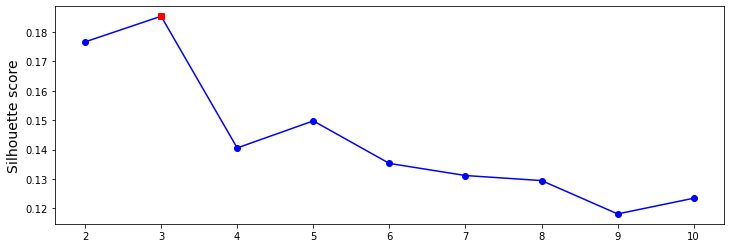

In [28]:
fig, ax = plt.subplots(figsize =(12,4))

ax.plot(k_list, silhouette_scores, "bo-") 

ax.set_xlabel("", fontsize=14) 
ax.set_ylabel("Silhouette score", fontsize=14)

ax.plot(best_k, best_score, "rs")
plt.show()

Extract all the inertias and find the best one 

In [44]:
inertias  = [model.inertia_ for model in kmeans_models]
best_inertia = inertias[best_index]
best_inertia

1724789.5

Plot the inertias 

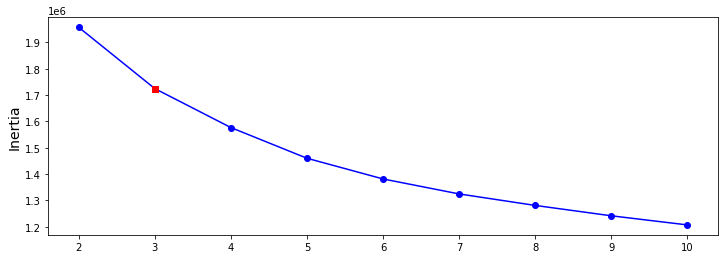

In [30]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(k_list, inertias, "bo-") 

ax.set_xlabel("", fontsize=14) 
ax.set_ylabel("Inertia", fontsize=14)

ax.plot(best_k, best_inertia, "rs")
plt.show()

Try to change algorithm hyperparameter to compare

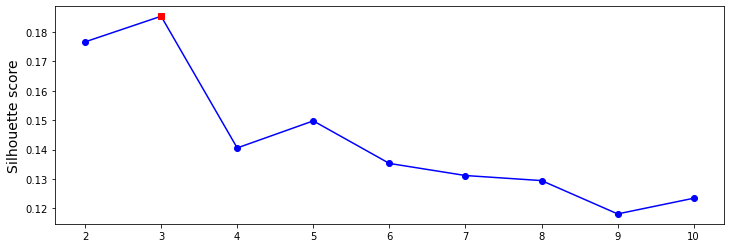

In [4]:
k_list = range(2,11,1)
kmeans_models_e = []
for k in k_list:
    kmeans_e = KMeans(n_clusters =k,
                    random_state=42,
                       n_init = 100,
                     algorithm="elkan")
    kmeans_e.fit(ds_x)
    kmeans_models_e.append(kmeans_e)
silhouette_scores_e = [silhouette_score(ds_x, model.labels_)
                     for model in kmeans_models_e]
best_index_e = np.array(np.argmax(silhouette_scores_e))
best_k_e = k_list[best_index_e]
best_score_e = silhouette_scores_e[best_index_e]
best_score_e
fig, ax = plt.subplots(figsize =(12,4))

ax.plot(k_list, silhouette_scores_e, "bo-") 

ax.set_xlabel("", fontsize=14) 
ax.set_ylabel("Silhouette score", fontsize=14)

ax.plot(best_k_e, best_score_e, "rs")
plt.show()

extract the best model and predict the cluster for each sample 

In [32]:
kmeans_best = kmeans_models[1]
labels = kmeans_best.predict(ds_x)

Make a dataframe with the environemntal variables, the basins and the cluster 

In [32]:
ds_plot = np.stack([ds_x[:,0],ds_x[:,1],ds_x[:,2],ds_x[:,3],ds_x[:,4],ds_x[:,5],ds_x[:,6],
                   ds_x[:,7],ds_x[:,8],ds_x[:,9],ds_x[:,10],ds_y,labels],
                  axis=1)
df_kmeans = pd.DataFrame(ds_plot, columns=['VSHD', 'RVOR', 'HDIV', 'MSLP', 'MLRH', 'TADV', 'THDV', 'RSST', 'BTWM', 'PCCD', 'PLND','basin','cluster'])
df_kmeans['cluster'] = df_kmeans['cluster'].astype(int)
df_kmeans['basin'] = df_kmeans['basin'].astype(int)
df_kmeans.to_pickle("df.pkl") # save to pickle to use it later without doing everything again

NameError: name 'ds_x' is not defined

In [2]:
df_kmeans = pd.read_pickle('df.pkl')# reload the dataframe when opening a new session

Cut the dataframe into 3 dataframe, one for each cluster 

In [3]:
df0_km = df_kmeans[df_kmeans['cluster']== 0]
df1_km = df_kmeans[df_kmeans['cluster']== 1]
df2_km = df_kmeans[df_kmeans['cluster']== 2]

bar graph representation for the basin variable

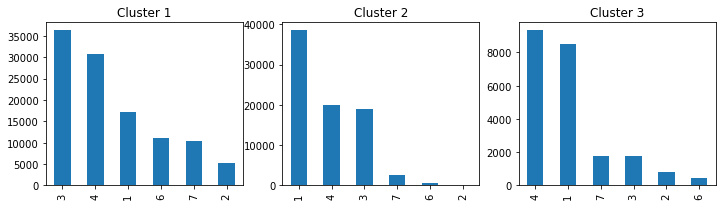

In [4]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (12,3))
df0_km['basin'].value_counts().plot(kind='bar',ax=ax1,title='Cluster 1')
df1_km['basin'].value_counts().plot(kind='bar',ax=ax2,title='Cluster 2')
df2_km['basin'].value_counts().plot(kind='bar',ax=ax3,title='Cluster 3')
plt.show()

boxplot representations

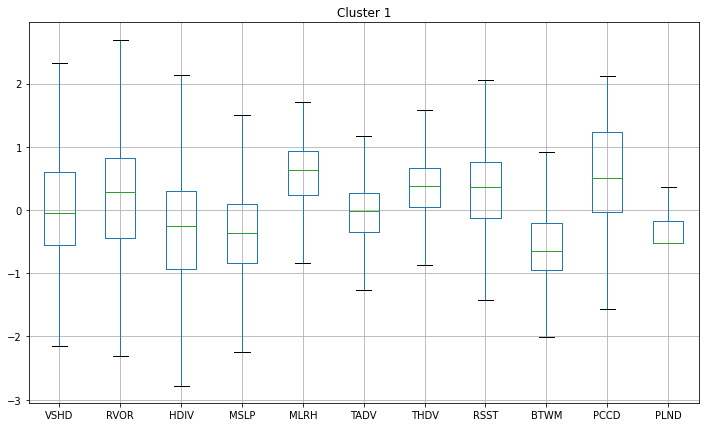

In [12]:
fig = df0_km.boxplot(column=['VSHD', 'RVOR', 'HDIV', 'MSLP', 'MLRH', 'TADV', 'THDV', 'RSST', 'BTWM', 'PCCD', 'PLND'],
               figsize=(12,7),sym=(''))
plt.title('Cluster 1')
plt.show()

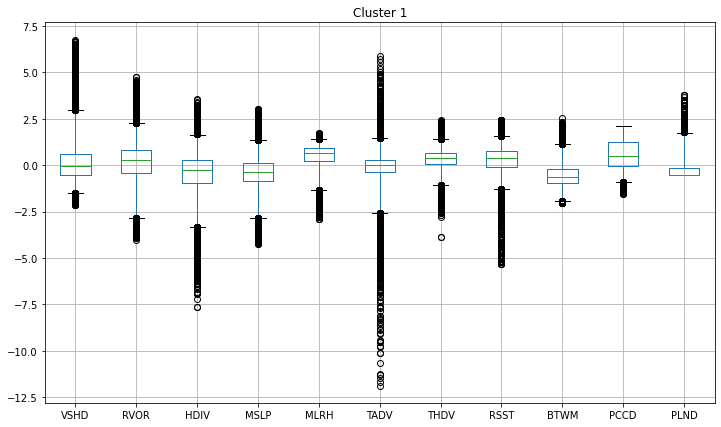

In [19]:
fig = df0_km.boxplot(column=['VSHD', 'RVOR', 'HDIV', 'MSLP', 'MLRH', 'TADV', 'THDV', 'RSST', 'BTWM', 'PCCD', 'PLND'],
               figsize=(12,7),whis=(1,99))
plt.title('Cluster 1')
plt.show()

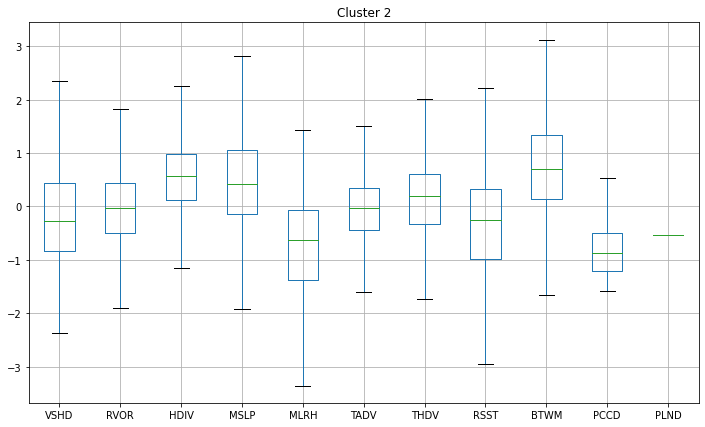

In [18]:
df1_km.boxplot(column=['VSHD', 'RVOR', 'HDIV', 'MSLP', 'MLRH', 'TADV', 'THDV', 'RSST', 'BTWM', 'PCCD', 'PLND'],
               figsize=(12,7),sym=('') )
plt.title('Cluster 2')
plt.show()

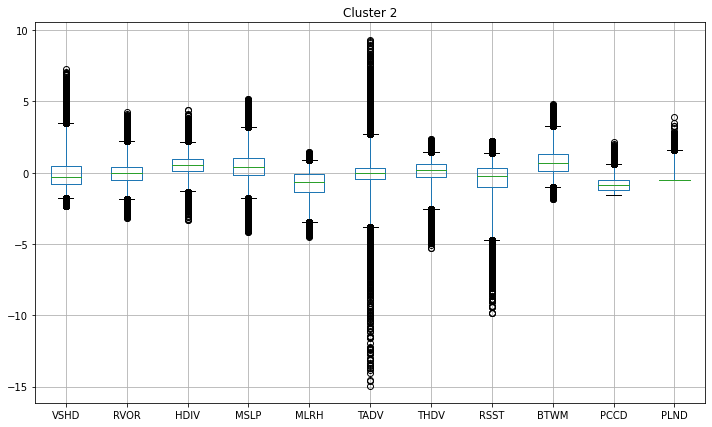

In [22]:
fig = df1_km.boxplot(column=['VSHD', 'RVOR', 'HDIV', 'MSLP', 'MLRH', 'TADV', 'THDV', 'RSST', 'BTWM', 'PCCD', 'PLND'],
               figsize=(12,7),whis=(1,99))
plt.title('Cluster 2')
plt.show()

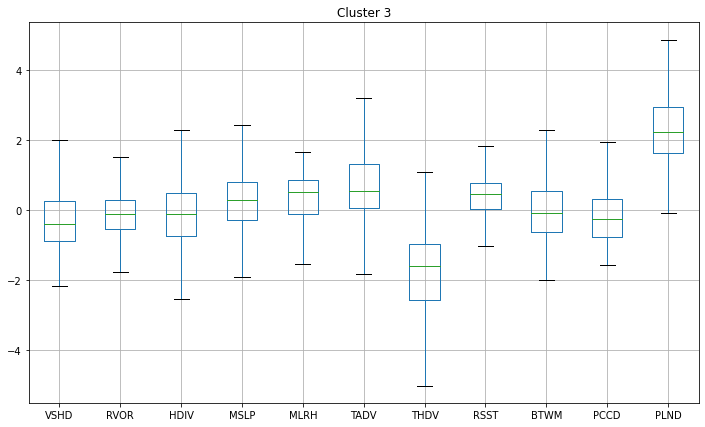

In [13]:
df2_km.boxplot(column=['VSHD', 'RVOR', 'HDIV', 'MSLP', 'MLRH', 'TADV', 'THDV', 'RSST', 'BTWM', 'PCCD', 'PLND'],
               figsize=(12,7),sym=('') )
plt.title('Cluster 3')
plt.show()

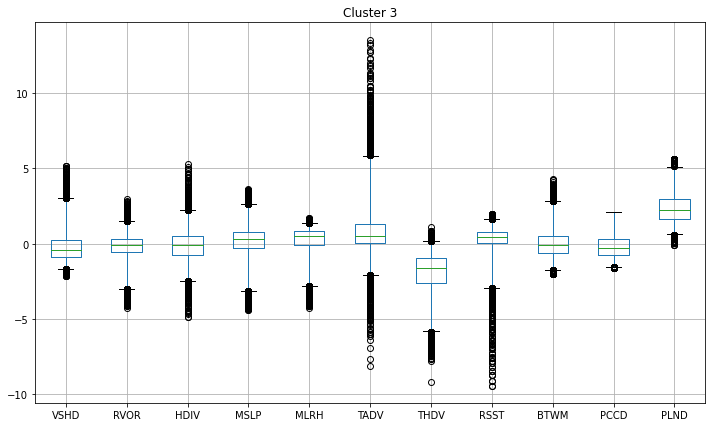

In [23]:
fig = df2_km.boxplot(column=['VSHD', 'RVOR', 'HDIV', 'MSLP', 'MLRH', 'TADV', 'THDV', 'RSST', 'BTWM', 'PCCD', 'PLND'],
               figsize=(12,7),whis=(1,99))
plt.title('Cluster 3')
plt.show()

CLUSTER WITH DBSCAN

Initialize k-nearest neighbors method and plot the distances

In [8]:
nn = NearestNeighbors(n_neighbors=100).fit(ds_x)
distances, indices = nn.kneighbors(ds_x)

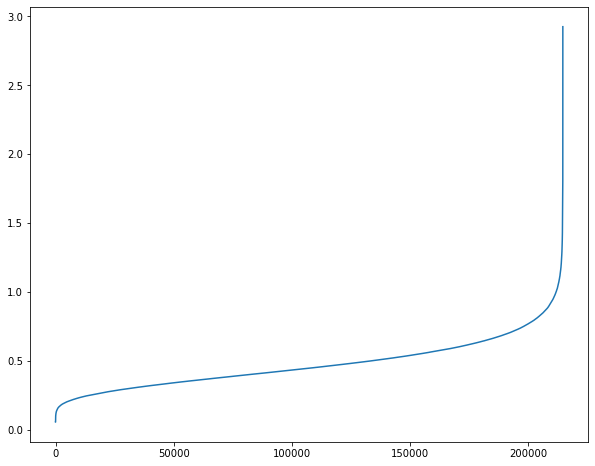

In [9]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)

Organize the data in dataframe and save it

In [21]:
DB_labels = DB.labels_
DB_plot = np.stack([ds_x[:,0],ds_x[:,1],ds_x[:,2],ds_x[:,3],ds_x[:,4],ds_x[:,5],ds_x[:,6],
                   ds_x[:,7],ds_x[:,8],ds_x[:,9],ds_x[:,10],ds_y,DB_labels],
                  axis=1)
df_DB = pd.DataFrame(DB_plot, columns=['VSHD', 'RVOR', 'HDIV', 'MSLP', 'MLRH', 'TADV', 'THDV', 'RSST', 'BTWM', 'PCCD', 'PLND','basin','cluster'])
df_DB['cluster'] = df_DB['cluster'].astype(int)
df_DB['basin'] = df_DB['basin'].astype(int)
df_DB.to_pickle("df_DB.pkl")

In [25]:
df_DB = pd.read_pickle('df_DB.pkl')# reload the dataframe when opening a new session

Divide the dataframe for both clusters

In [26]:
df0_DB = df_DB[df_DB['cluster']== 0]
df1_DB = df_DB[df_DB['cluster']== 1]

bar graph representation for the basin variable

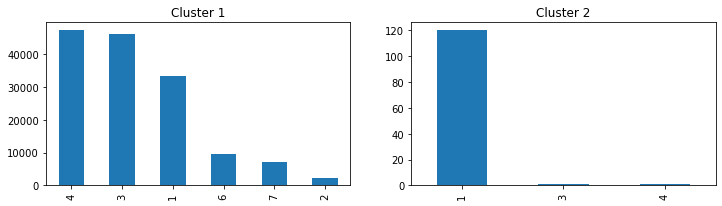

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (12,3))
df0_DB['basin'].value_counts().plot(kind='bar',ax=ax1,title='Cluster 1')
df1_DB['basin'].value_counts().plot(kind='bar',ax=ax2,title='Cluster 2')
plt.show()

Boxplot representations

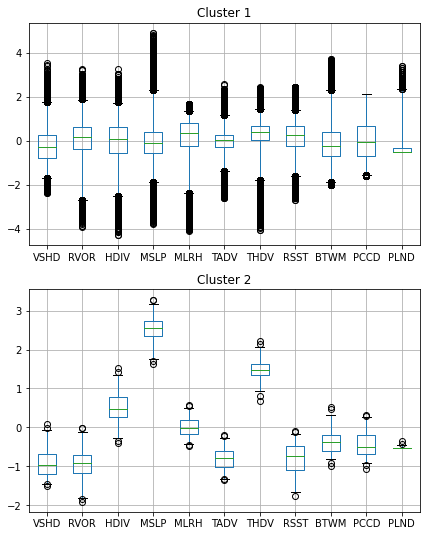

In [59]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (7,9))
df0_DB.boxplot(column=['VSHD', 'RVOR', 'HDIV', 'MSLP', 'MLRH', 'TADV', 'THDV', 'RSST', 'BTWM', 'PCCD', 'PLND'],
               figsize=(12,7),whis=(1,99),ax=ax1)
ax1.title.set_text('Cluster 1')
df1_DB.boxplot(column=['VSHD', 'RVOR', 'HDIV', 'MSLP', 'MLRH', 'TADV', 'THDV', 'RSST', 'BTWM', 'PCCD', 'PLND'],
               figsize=(12,7),whis=(1,99),ax=ax2)
plt.title('Cluster 2')
plt.show()

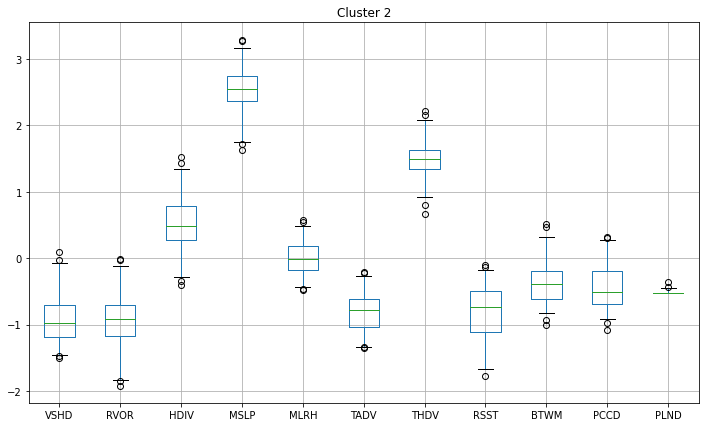

In [30]:
fig = df1_DB.boxplot(column=['VSHD', 'RVOR', 'HDIV', 'MSLP', 'MLRH', 'TADV', 'THDV', 'RSST', 'BTWM', 'PCCD', 'PLND'],
               figsize=(12,7),whis=(1,99))
plt.title('Cluster 2')
plt.show()